## Summary
I really liked this [kernel](https://www.kaggle.com/the1owl/classify-me-again). I think it is very creative and funny to create a model to predict personality from a text and to apply it over kaggle comments. This kernel is a variation of the indicated one where I calculate the accuracy of that model and try other model alternatives. At the end, we apply our best model to know what are the Kaggle community most common personalities, but don't take it too seriously :-)

In [1]:
!pip install plotly

In [2]:
import plotly.express as px

In [3]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

py.init_notebook_mode(connected=True)

In [4]:
train = pd.read_csv('C:/Users/TJ/Downloads/W-master/W-master/mbti_1.csv')
us = pd.read_csv('C:/Users/TJ/Downloads/W-master/W-master/mbti_1.csv')
ps = pd.read_csv('C:/Users/TJ/Downloads/W-master/W-master/mbti_1.csv')
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}

In [5]:
train.shape

(8675, 2)

In [6]:
train.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


We take a look to the classes. It looks like it is a very unbalanced dataset:

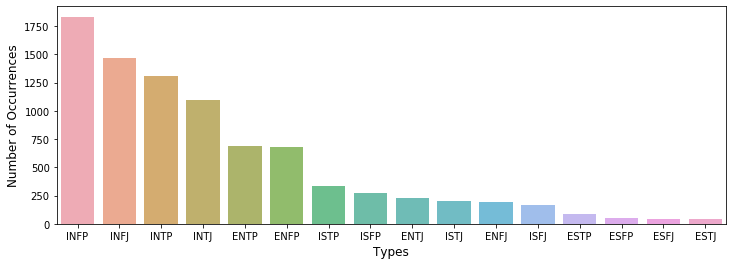

In [7]:
cnt_srs = train['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

### ExtraTreesClassifier with SVD
this is the model used in the  [kernel](https://www.kaggle.com/the1owl/classify-me-again). We want to evaluate its performance.

In [8]:
etc = ExtraTreesClassifier(n_estimators = 20, max_depth=4, n_jobs = -1)
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)
model = Pipeline([('tfidf1', tfidf), ('tsvd1', tsvd), ('etc', etc)])

In [9]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [10]:
np.random.seed(1)

scoring = {'acc': 'accuracy',
           'neg_log_loss': 'neg_log_loss',
           'f1_micro': 'f1_micro'}

results = cross_validate(model, train['posts'], train['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)

In [11]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_acc']),
                                                          np.std(results['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_f1_micro']),
                                                          np.std(results['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results['test_neg_log_loss']),
                                                          np.std(-1*results['test_neg_log_loss'])))

CV Accuracy: 0.3010 (+/- 0.0132)
CV F1: 0.3010 (+/- 0.0132)
CV Logloss: 2.1325 (+/- 0.0127)


As the dataset is very unbalanced F1 score is a better metric than accuracy

## Alternative models
Let's try if we can find a more accuracy model, although we haven't got a lot of data

In [12]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    return text

In [13]:
train['clean_posts'] = train['posts'].apply(cleanText)

### Naive Bayes

In [14]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1, 1), 
                         stop_words='english',
                         lowercase = True, 
                         max_features = 5000)

model_nb = Pipeline([('tfidf1', tfidf2), ('nb', MultinomialNB())])

results_nb = cross_validate(model_nb, train['clean_posts'], train['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)


In [15]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_acc']),
                                                          np.std(results_nb['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_f1_micro']),
                                                          np.std(results_nb['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_nb['test_neg_log_loss']),
                                                          np.std(-1*results_nb['test_neg_log_loss'])))

CV Accuracy: 0.5592 (+/- 0.0099)
CV F1: 0.5592 (+/- 0.0099)
CV Logloss: 6.2340 (+/- 0.3688)


### Logistic Regression

In [16]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1, 1), stop_words='english',
                                                 lowercase = True, max_features = 5000)

model_lr = Pipeline([('tfidf1', tfidf2), ('lr', LogisticRegression(class_weight="balanced", C=0.005))])

results_lr = cross_validate(model_lr, train['clean_posts'], train['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)

In [17]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_acc']),
                                                          np.std(results_lr['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_f1_micro']),
                                                          np.std(results_lr['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_lr['test_neg_log_loss']),
                                                          np.std(-1*results_lr['test_neg_log_loss'])))

CV Accuracy: 0.6526 (+/- 0.0146)
CV F1: 0.6526 (+/- 0.0146)
CV Logloss: 1.3122 (+/- 0.0150)


Is this model overtitting? could we have a better model with more data? Let's see the learning curve:

In [18]:
train_sizes, train_scores, test_scores = \
    learning_curve(model_lr, train['clean_posts'], train['type'], cv=kfolds, n_jobs=-1, 
                   scoring="f1_micro", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

In [19]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

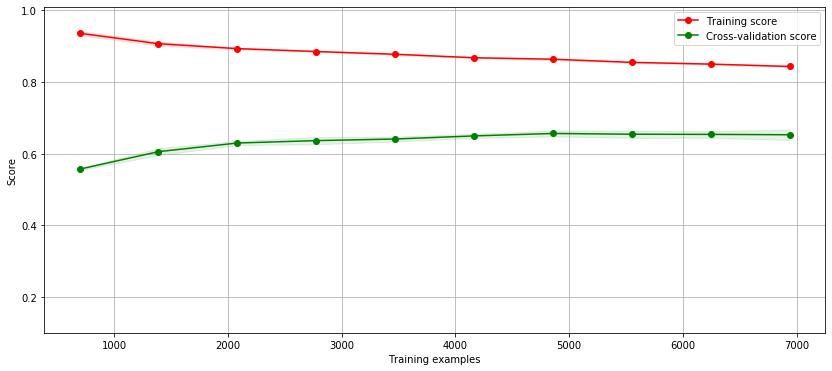

In [20]:
import matplotlib.pyplot as plt

plot_learning_curve(train['posts'], train['type'], train_sizes, 
                    train_scores, test_scores, ylim=(0.1, 1.01), figsize=(14,6))
plt.show()

It looks like that with more data the model gets better and that it is not overfitting. 

In [21]:
myeong = pd.read_excel('C:/Users/TJ/Downloads/W-master/W-master/명동.xlsx')

In [22]:
myeong.head(10)

,Unnamed: 0,score,text
0,12,5.0,"Great place to stroll around, lots of street i..."
1,13,5.0,"This place was so great, I visited on 3 separa..."
2,14,5.0,This is great to see at night when eveyrhing i...
3,15,5.0,Me encanto para ir de compras encuentras lo qu...
4,16,5.0,you should not miss out on the Street food and...
5,17,4.0,Myeong Dong is a commercial south of the City ...
6,18,5.0,This is the shooting site of RUNNING MAN. I li...
7,19,5.0,i feel like heaven in thiz place because of th...
8,20,5.0,Myeongdong is a lively place to visit for the ...
9,21,5.0,it’s a shopping area. lots of restaurants and ...


In [23]:
myeong.columns

Index(['Unnamed: 0', 'score', 'text'], dtype='object')

In [24]:
myeong=myeong.drop('Unnamed: 0',axis=1)

In [25]:
myeong.head()

,score,text
0,5.0,"Great place to stroll around, lots of street i..."
1,5.0,"This place was so great, I visited on 3 separa..."
2,5.0,This is great to see at night when eveyrhing i...
3,5.0,Me encanto para ir de compras encuentras lo qu...
4,5.0,you should not miss out on the Street food and...


In [26]:
myeong['clean_post'] = myeong['text'].apply(cleanText)

In [27]:
myeong

,score,text,clean_post
0,5.0,"Great place to stroll around, lots of street i...","Great place to stroll around, lots of street i..."
1,5.0,"This place was so great, I visited on 3 separa...","This place was so great, I visited on 3 separa..."
2,5.0,This is great to see at night when eveyrhing i...,This is great to see at night when eveyrhing i...
3,5.0,Me encanto para ir de compras encuentras lo qu...,Me encanto para ir de compras encuentras lo qu...
4,5.0,you should not miss out on the Street food and...,you should not miss out on the Street food and...
...,...,...,...
403,5.0,"Located in central Seoul, it is a representati...","Located in central Seoul, it is a representati..."
404,5.0,kampungku restaurant Islamic food is best and ...,kampungku restaurant Islamic food is best and ...
405,5.0,"For people who love shopping, this is a paradi...","For people who love shopping, this is a paradi..."
406,5.0,Mingdong in Seoul is a paradise for young peop...,Mingdong in Seoul is a paradise for young peop...


In [1]:
myeong_predict=model_lr.predict(myeong)

NameError: name 'model_lr' is not defined

In [ ]:
myeong_predict